In [49]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 5)
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox

from tqdm.notebook import tqdm
from itertools import product
from typing import Union
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Ingest and EDA

In [50]:
# Get the prepared dataset from the local python file
from functions import get_prepared_data

In [51]:
# Train and test set
weather_train = get_prepared_data(set='train')
weather_test = get_prepared_data(set='test')

In [52]:
weather_train.shape, weather_test.shape

((1461, 10), (114, 10))

In [53]:
weather_train.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day_of_month,weekday,quarter,day_of_year
date,,,,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1,1,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,2,2,1,2
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,3,3,1,3
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,4,4,1,4
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,5,5,1,5


In [54]:
weather_test.head()

,meantemp,humidity,wind_speed,meanpressure,year,month,day_of_month,weekday,quarter,day_of_year
date,,,,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,2017,1,1,6,1,1
2017-01-02,18.500000,77.222222,2.894444,1018.277778,2017,1,2,0,1,2
2017-01-03,17.111111,81.888889,4.016667,1018.333333,2017,1,3,1,1,3
2017-01-04,18.700000,70.050000,4.545000,1015.700000,2017,1,4,2,1,4
2017-01-05,18.388889,74.944444,3.300000,1014.333333,2017,1,5,3,1,5


In [55]:
# Decomposition
weather_decomposition = STL(weather_train["meantemp"], period=365).fit()

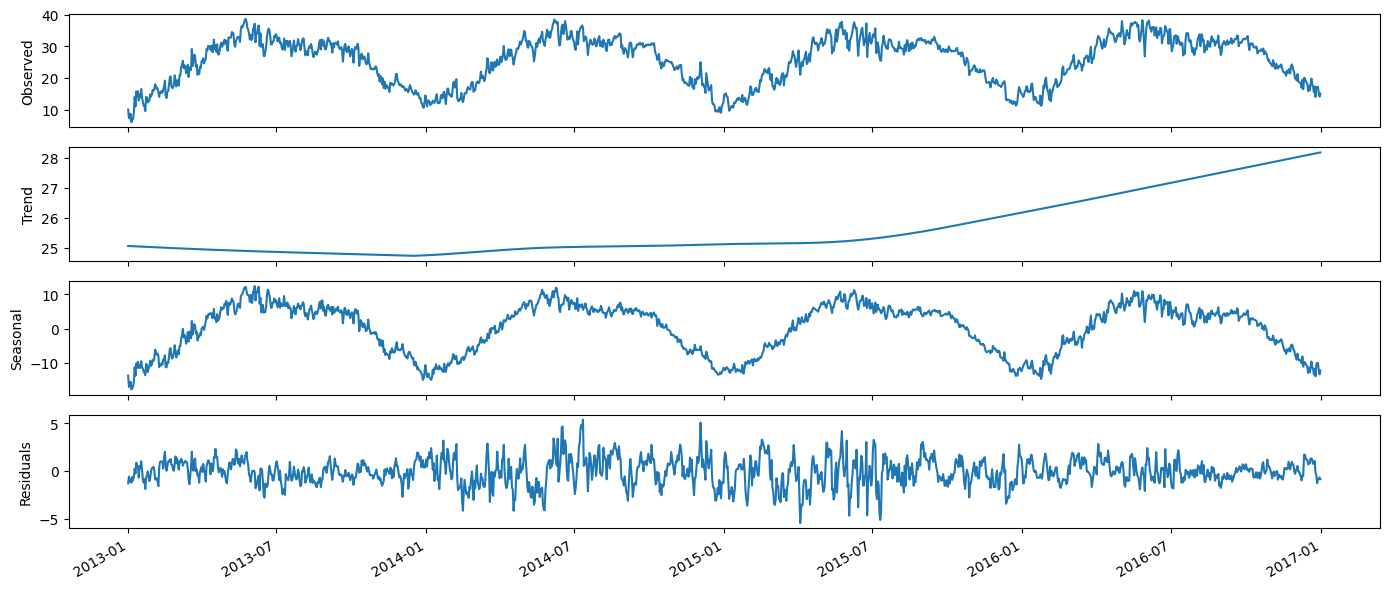

In [56]:
# Visualize the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(14, 6))

ax1.plot(weather_decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(weather_decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(weather_decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(weather_decomposition.resid)
ax4.set_ylabel('Residuals')



fig.autofmt_xdate()
plt.tight_layout()

The data has been decomposed during eda
The data has been confirmed not to be a random walk during EDA

Check for stationarity

In [57]:
ADF_result = adfuller(weather_train["meantemp"], )

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -2.15556522744643
p-value: 0.2227659398673355


The p value > 0.05. The data does not provide enough reason to reject the null hypothesis which states that the time series is not stationary

Transforme the dataset to achieve stationarity

In [58]:
mean_temp_diff = np.diff(weather_train["meantemp"], n=1)

ADF_result = adfuller(mean_temp_diff)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -16.52044059233267
p-value: 2.0666135559465838e-29


The p value is < 0.05
Therefore we reject the null hypothesis and conclude tha the data is now stationary

`d=1`

In [ ]:
Lets model the endogenous variable alone

## Train test

In [59]:
# Train and test set
train = weather_train.loc[:, "meantemp"]
test = weather_test.loc[:, "meantemp"]

In [60]:
train.shape, test.shape

((1461,), (114,))

In [61]:
train.head()

date
2013-01-01    10.000000
2013-01-02     7.400000
2013-01-03     7.166667
2013-01-04     8.666667
2013-01-05     6.000000
Freq: D, Name: meantemp, dtype: float64

## SARIMA

Let's train the model with different values for p, P, q, Q. 

The Akaike informaton criterion (AIC) will heip us to select the optimal model. 
The AIC estimates the quality of one model relative to other modls

Given that there will be some information lost when a model is fitted to the data, the AIC quantifies the relative amount of information lost by the model. 

The less information lost, the lower the AIC value and the better the model.

In [62]:
# Fit models with various values of P,p, Q,q and get a dataframe with AIC of differnt models
def optimize_SARIMA(endog: Union[pd.Series, list], 
                    order_list: list, 
                    d: int, 
                    D: int, 
                    s: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(
                endog, 
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [63]:
# The differnt values  for p,P,Q,q that we'll try
ps = range(0, 4, 1) # values from last 3 days
qs = range(0, 4, 1) # errors from last 3 days
Ps = range(0, 4, 1) # values from last season
Qs = range(0, 4, 1) # errors from last season

In [64]:
# List all possible combination of those values
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
# How many are they in total
len(SARIMA_order_list)

256

In [65]:
d = 1
D = 0
s = 365

In [66]:
# # Now implement Optimize sarima
# SARIMA_result_df = optimize_SARIMA(weather_train["meantemp"], SARIMA_order_list, d, D, s)
# SARIMA_result_df

It is unrealistic to train SARIMA with s = 365
It takes way too much time

Let's try something else. We know that the data from a particular month this year should inform that same particular month the following year. 
try `s=30`

In [67]:
d = 1
D = 0
s = 30

In [68]:
# The differnt values  for p,P,Q,q that we'll try
ps = range(0, 4, 1) # values from last 3 days
qs = range(0, 4, 1) # errors from last 3 days
Ps = range(0, 24, 6) # values from last x months
Qs = range(0, 24, 6) # errors from last x months

In [69]:
# List all possible combination of those values
SARIMA_order_list = list(product(ps, qs, Ps, Qs))
# How many are they in total
len(SARIMA_order_list)

256

In [70]:
# # Now implement Optimize sarima
# SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, s)
# SARIMA_result_df

conclusion. The seasonality component makes the training take too much time.  
It is not feasible